<a href="https://colab.research.google.com/github/Leoace02/Leoace02/blob/main/Lip_reading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import os
import cv2
import tensorflow as tf
import gdown
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# Model libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv3D,LSTM, Dropout,Bidirectional, Activation, SpatialDropout3D, BatchNormalization, MaxPool3D,Reshape, Flatten,TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
# Check for GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Download the dataset
url= "https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL"
output = 'data.zip'
gdown.download(url,output,quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:01<00:00, 215MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

## The Videoloader module will create a tensorflow dataset combining both the frames and subtitles.
* Videos - Opencv to capture the frame and grayscale and crop it at [190:236] lip area and convert to numeric.
* Text - Convert to char to numeric using stringlookup.
* Encapsulate both and create a dataset.

Note: Use Collab, the OS functions is written with respect to collab and not windows.

In [ ]:
class VideoDataLoader:
    def __init__(self):
        # This is an empty constructor; nothing to initialize here.
        return

    def load_video(self, path: str) -> List[float]:
        # Load video frames and extract the cropped lip part
        cap = cv2.VideoCapture(path)
        frames = []
        for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
            ret, frame = cap.read()
            frame = tf.image.rgb_to_grayscale(frame)
            frames.append(frame[190:236, 80:220, :])  # Cropped lip part of each frame
        cap.release()

        # Scaling each frame
        mean = tf.math.reduce_mean(frames)
        std = tf.math.reduce_std(tf.cast(frames, tf.float32))
        return tf.cast((frames - mean), tf.float32) / std

    def load_alignments(self, path: str) -> List[str]:
        # Load alignments from a file
        with open(path, 'r') as f:
            lines = f.readlines()
        tokens = []
        for line in lines:
            line = line.split()
            if line[2] != 'sil':
                tokens = [*tokens, ' ', line[2]]
        return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

    def load_data(self, path: str):
        # Load video frames and alignments for a given path
        path = bytes.decode(path.numpy())
        filename = path.split('/')[-1].split('.')[0]  # colab
        video_path = os.path.join('data', 's1', f'{filename}.mpg')
        alignment_path = os.path.join('data', 'alignments', 's1', f'{filename}.align')
        frames = self.load_video(video_path)
        alignments = self.load_alignments(alignment_path)
        return frames, alignments

    def mappable_function(self, path: str) -> List[str]:
        # Wrapper function for loading data using tf.py_function
        result = tf.py_function(self.load_data, [path], (tf.float32, tf.int64))
        return result

    def create_dataset(self, data_path: str):
      # Create a TensorFlow dataset from a list of file paths
      data = tf.data.Dataset.list_files(data_path)

      # Shuffle the dataset with a buffer size of 500 and disable reshuffling on each iteration
      data = data.shuffle(500, reshuffle_each_iteration=False)

      # Apply the mappable_function to each element in the dataset
      data = data.map(self.mappable_function)

      # Pad the batch to have a fixed shape, where the first dimension is batch size (2),
      # and the second dimension is the maximum sequence length for frames (75),
      # None indicates variable frame height, width, and channels, and the second element
      # is the maximum sequence length for alignments (40)
      data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))

      # Prefetch the dataset to optimize data loading
      data = data.prefetch(tf.data.AUTOTUNE)

      # Split the dataset into training data (first 450 batches)
      train_data = data.take(450)

      # Skip the first 450 batches to obtain test data
      test_data = data.skip(450)

      # Create a numpy iterator for the remaining data (validation set)
      test1 = data.as_numpy_iterator()
      val = test1.next()

      # Return the training data, test data, and validation batch
      return train_data, test_data, val,data


# Define vocabulary and char_to_num outside the class
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")  # Converts char to num
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)  # Converts num to char

print(f"the vocabulary is : {char_to_num.get_vocabulary()}\n"
      f"size is : {char_to_num.vocabulary_size()}")

# Create an instance of the VideoDataLoader
data_loader = VideoDataLoader()
train, test, val,data = data_loader.create_dataset('/content/data/s1/*.mpg')


the vocabulary is : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']
size is : 40


In [ ]:
len(data)

500

## Model Building

* Convultional neural network with LSTM.

In [ ]:
# Create a Sequential model
model = Sequential()

# Convolutional 3D layer with 128 filters, kernel size 3, and input shape (75, 46, 140, 1)
# Padding is set to 'same' to keep the spatial dimensions unchanged
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))  # Apply ReLU activation function
model.add(MaxPool3D((1, 2, 2)))  # 3D Max pooling with pool size (1, 2, 2)

# Convolutional 3D layer with 256 filters and kernel size 3
model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

# Convolutional 3D layer with 75 filters and kernel size 3
model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

# Apply TimeDistributed layer followed by Flatten to process the entire 3D volume in each time step
model.add(TimeDistributed(Flatten()))

# Bidirectional LSTM layer with 128 units, using Orthogonal initialization, and returning sequences
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))  # Apply Dropout for regularization

# Bidirectional LSTM layer with 128 units, using Orthogonal initialization, and returning sequences
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))  # Apply Dropout for regularization

# Dense layer with units equal to the size of the vocabulary + 1 (for the 'oov_token'),
# using he_normal initialization and softmax activation for output probabilities
model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

## Model training parameter functions

In [ ]:
# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# CTC Loss function
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
    input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
    label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

    # Calculate CTC loss using TensorFlow's ctc_batch_cost
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        # Initialize the callback with a dataset iterator
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        # Execute at the end of each training epoch
        data = self.dataset.next()  # Get the next batch from the dataset iterator
        yhat = self.model.predict(data[0])  # Make predictions using the trained model

        # Decode the predictions using CTC decoding with greedy=False
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()

        # Print original and predicted sequences for each example in the batch
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~' * 100)


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=CTCLoss)

# ModelCheckpoint callback to save weights during training
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint'), monitor='loss', save_weights_only=True)

# LearningRateScheduler callback to adjust learning rate during training
schedule_callback = LearningRateScheduler(scheduler)

# Example callback (assuming 'ProduceExample' is a custom callback class)
example_callback = ProduceExample(data)

# Encapsulation of callback instances
callbacks = [checkpoint_callback, schedule_callback, example_callback]

In [ ]:
# Don't run this , will take 3 - 4 days in T4 Collab GPU.
model.fit(train, validation_data=test, epochs=100, callbacks=callbacks, )

Epoch 1/100


KeyboardInterrupt: ignored

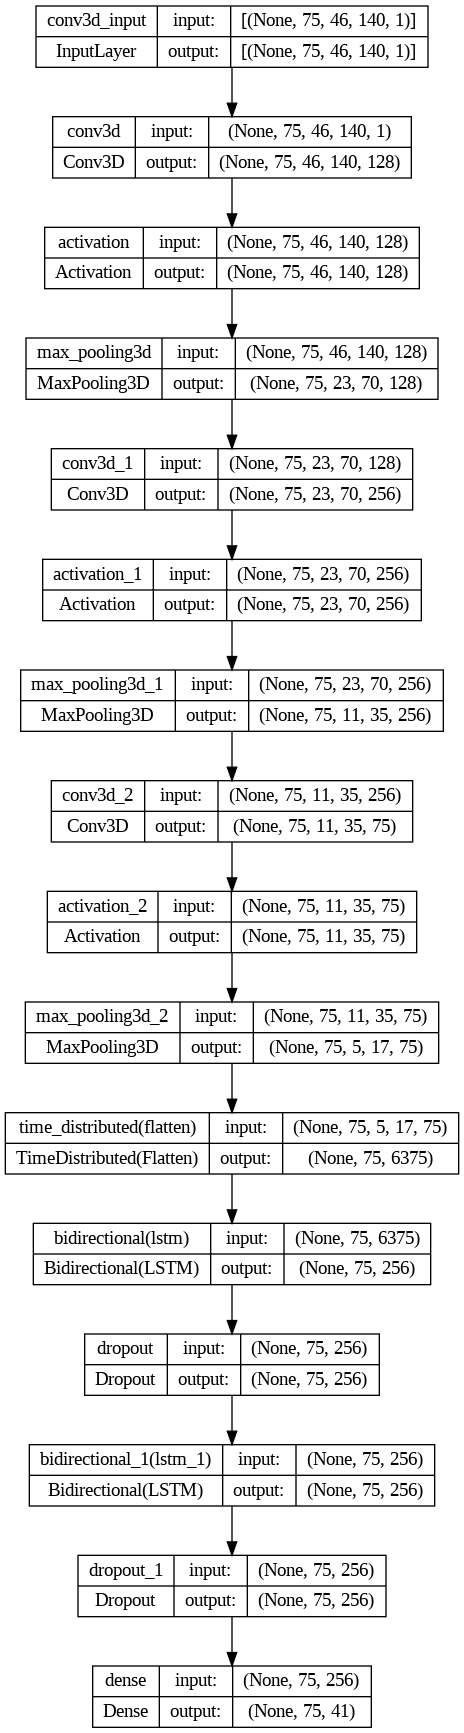

In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your Sequential model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Downloading the stored model weights

url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 152MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [ ]:

model.load_weights('models/checkpoint')

#**Results**

# Taking a sample from test and predicting

In [ ]:

sample = test.as_numpy_iterator().next()

yhat = model.predict(sample[0])


print('~'*100, 'REAL TEXT')
print([tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]])


decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
print('~'*100, 'PREDICTIONS')
print([tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded])


1/1 [==============================] - 1s 1s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
[<tf.Tensor: shape=(), dtype=string, numpy=b'set green at i eight please'>, <tf.Tensor: shape=(), dtype=string, numpy=b'lay green by s seven soon'>]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
[<tf.Tensor: shape=(), dtype=string, numpy=b'set green at i eight pleasee'>, <tf.Tensor: shape=(), dtype=string, numpy=b'lay green by s s seven soon'>]


### Creating a true_list and pred_list of all the sentences to create the confusion matrix.

In [ ]:
predictions = model.predict(test)


50/50 [==============================] - 228s 608ms/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(predictions, input_length=[75,75]*50, greedy=True)[0][0].numpy()
pred_list=[tensor.numpy() for tensor in [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]]

In [ ]:
ground_truth_list = []

for frames, alignments in test:
    # alignments is a NumPy array with shape (batch_size, 40)
    ground_truth_list.append(alignments)
    print(alignments)

# Concatenate the list of ground truth arrays into a single NumPy array
x_true = np.concatenate(ground_truth_list, axis=0)

tf.Tensor(
[[16 12  1  3  5 39  2 12 21  5 39  9 14 39  2 39  5  9  7  8 20 39 16 12
   5  1 19  5  0  0  0  0  0  0  0  0  0  0  0  0]
 [16 12  1  3  5 39  7 18  5  5 14 39  2 25 39  5 39 20 23 15 39 14 15 23
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]], shape=(2, 40), dtype=int64)
tf.Tensor(
[[16 12  1  3  5 39 18  5  4 39  1 20 39 10 39 20  8 18  5  5 39  1  7  1
   9 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [16 12  1  3  5 39  2 12 21  5 39 23  9 20  8 39 16 39  5  9  7  8 20 39
  16 12  5  1 19  5  0  0  0  0  0  0  0  0  0  0]], shape=(2, 40), dtype=int64)
tf.Tensor(
[[16 12  1  3  5 39  7 18  5  5 14 39  2 25 39 11 39 19  9 24 39 14 15 23
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  9 14 39  7 18  5  5 14 39  2 25 39  2 39 20  8 18  5  5 39  1  7  1
   9 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0]], shape=(2, 40), dtype=int64)
tf.Tensor(
[[12  1 25 39 23  8  9 20  5 39  9 14 39 11 39  5  9  7  8 20 39 14 15 23
   0  0  0  0  0  0  0  0  0  0  0  0  0  

In [ ]:
len(x_true)

100

In [ ]:

true_list=[tensor.numpy() for tensor in [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in x_true]]

In [ ]:
from fuzzywuzzy import fuzz

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


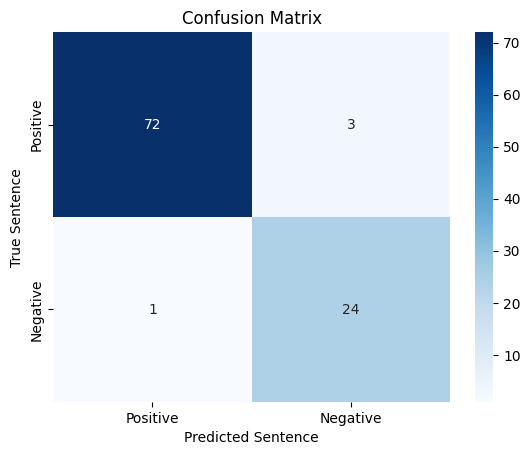

In [ ]:
from sklearn.metrics import confusion_matrix
true_list = [str(item, 'utf-8') for item in true_list]
pred_list = [str(item, 'utf-8') for item in pred_list]

threshold=60

def classify_sentences(true, pred):
    similarity_score = fuzz.ratio(true, pred)
    return similarity_score >= threshold

# Map the actual and predicted values to binary labels
binary_labels_true = [classify_sentences(true_sent, pred_list[idx]) for idx, true_sent in enumerate(true_list)]
binary_labels_pred = [classify_sentences(pred_sent, true_list[idx]) for idx, pred_sent in enumerate(pred_list)]

# Create confusion matrix
conf_matrix = confusion_matrix(binary_labels_true, binary_labels_pred)

# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.xlabel('Predicted Sentence')
plt.ylabel('True Sentence')
plt.title('Confusion Matrix')
plt.show()


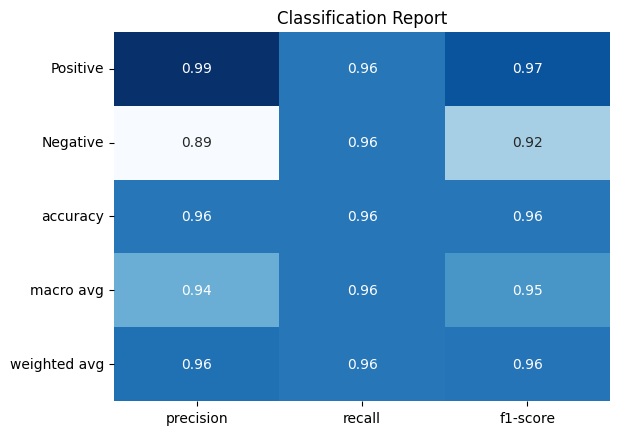

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
class_report = classification_report(binary_labels_true, binary_labels_pred, target_names=['Positive', 'Negative'], output_dict=True)

# Plot the classification report
sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True, cmap='Blues', fmt=".2f", cbar=False)
plt.title('Classification Report')
plt.show()

# **Conclusion**

* Model is the lipreading model and the model is able to predict the lip moment for 72 videos out of 100 videos. So the accuracy is 72%.